(schreiber_article)=
# Schreiber's TE Article

In this notebook, we reproduce the numerical experiments described in Thomas Schreiber’s seminal paper **“Measuring Information Transfer”** (2000) {cite:p}`Schreiber.paper`, focusing on two canonical systems: the **tent map** lattice and the **Ulam map** lattice. The goal is to compute and visualize {ref}`transfer_entropy_overview` and {ref}`mutual_information_overview` under varying coupling strengths, using discrete and the kernel-based estimators implemented via the `infomeasure` Python package. The methodology closely follows Schreiber’s formulations.

In [5]:
import infomeasure as im
import numpy as np
import matplotlib.pyplot as plt
im.Config.set_logarithmic_unit("bits")

## Example 1: Unidirectionally Coupled Tent Maps

In this section, we simulate a 1D lattice of 100 coupled tent maps with unidirectional coupling. The system evolves according to the equation:

$$
x_n^m = f\left( \epsilon x_n^{m-1} + (1 - \epsilon) x_n^m \right),
$$

where the tent map function is defined as:

$$
f(x) =
\begin{cases}
2x, & \text{if } x < 0.5 \\
2 - 2x, & \text{if } x \geq 0.5
\end{cases}
$$

Each state $x_n^m$ is coarse-grained into binary form by thresholding at $x = 0.5$, producing a symbolic sequence $I_n^m \in \{0, 1\}$.

We compute the transfer entropy from site $m-1$ to site $m$ using a history length of $1$ and binary partitions. Transfer entropy is estimated across a range of coupling strengths $\epsilon \in [0, 0.05]$ and averaged over 10 independent runs ( one can increase this run to reduce the statistical fluctation).

For small coupling, the theoretical form is:

$$
T_{I_{m-1} \rightarrow I_m} \approx \frac{\alpha^2 \epsilon^2}{\ln 2}, \quad \text{with } \alpha \approx 0.77.
$$

$\alpha$ has been determined with a fit.
We are using the value Schreiber obtained.
This experiment demonstrates how TE increases with coupling in the correct direction, while remaining zero in the reverse, validating its directional sensitivity.

In [6]:
def tent_map(x):
    """
    Apply the tent map function element-wise to an array.

    f(x) = 2x            if x < 0.5
           2 - 2x        if x >= 0.5

    Parameters:
    - x: NumPy array of floats in [0, 1]

    Returns:
    - NumPy array of transformed values
    """
    return np.where(x < 0.5, 2 * x, 2 - 2 * x)


def generate_data(epsilon, num_maps=100, transient=100000, num_iterations=100000):
    """
    Simulates a 1D unidirectionally coupled tent map lattice.

    Parameters:
    - epsilon: Coupling strength (float between 0 and 1)
    - num_maps: Number of lattice sites (default 100)
    - transient: Number of iterations to discard before measurement (default 100000)
    - num_iterations: Number of iterations to keep after transients (default 100000)

    Returns:
    - binary_data: NumPy array (num_iterations x num_maps) with values 0 or 1 (binary partition)
    """
    # Initial random state for each map
    x = np.random.rand(num_maps)

    # Run transient iterations (discarded)
    for _ in range(transient):
        x = tent_map(epsilon * np.roll(x, 1) + (1 - epsilon) * x)

    # Initialize array to store post-transient values
    data = np.zeros((num_iterations, num_maps))
    data[0] = x

    # Simulate system for recording
    for t in range(1, num_iterations):
        data[t] = tent_map(
            epsilon * np.roll(data[t - 1], 1) + (1 - epsilon) * data[t - 1]
        )

    # Apply binary partition (threshold at 0.5)
    binary_data = (data >= 0.5).astype(int)
    return binary_data

In [7]:
# --- Coupling strengths from 0 to 0.05 in steps of 0.002 ---
couplings = np.arange(0, 0.052, 0.002)

# --- Lists to store mean and standard error of TE estimates ---
TE_mean = []
TE_std_err = []

# --- Loop over each coupling strength ---
for eps in couplings:
    te_runs = []  # Store TE values for multiple runs

    # Repeat simulation 10 times for averaging
    for run in range(10):
        binary_data = generate_data(eps)

        # Select two adjacent sites: m-1 and m
        x = binary_data[:, -2]  # site m-1
        y = binary_data[:, -1]  # site m

        # Estimate Transfer Entropy: m-1 → m
        estimator = im.estimator(
            x,
            y,
            measure="te",
            approach="discrete",  # Use discrete estimator for symbolic (binary) input
        )
        te_value = estimator.effective_val()
        te_runs.append(te_value)

    # Store mean and standard error
    TE_mean.append(np.mean(te_runs))
    TE_std_err.append(np.std(te_runs) / np.sqrt(len(te_runs)))

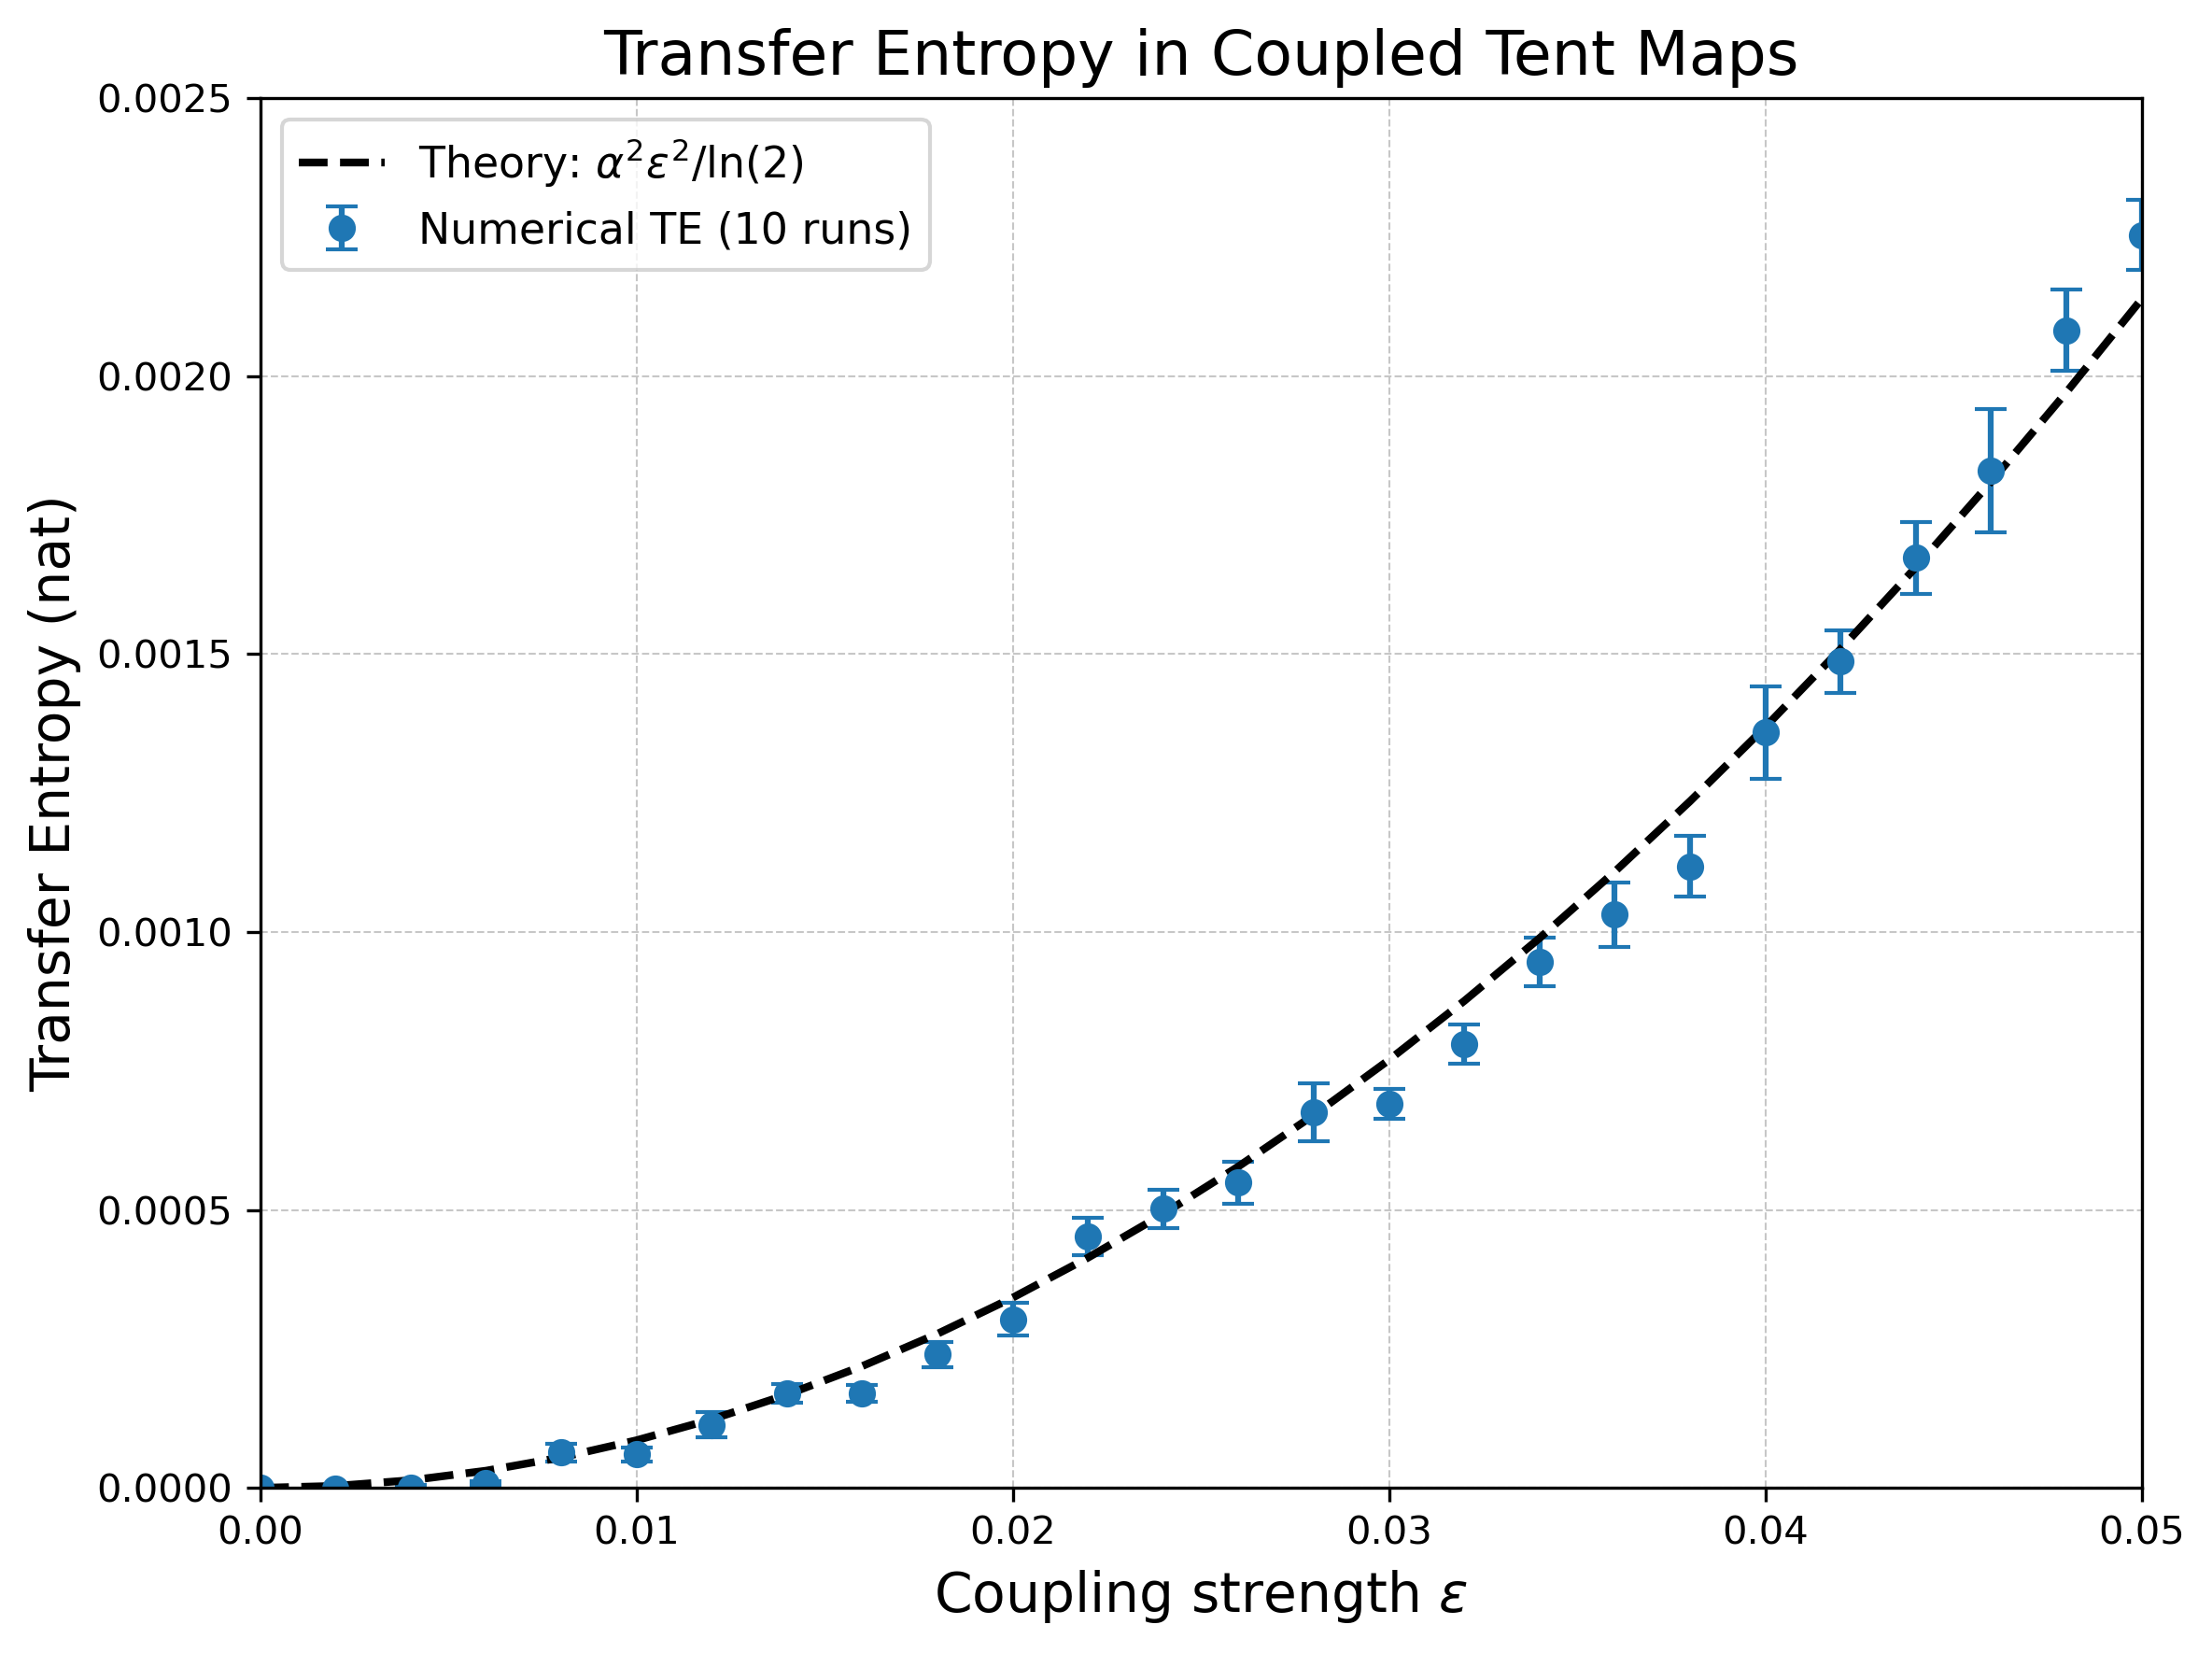

In [8]:
# --- Plotting Results ---
plt.figure(figsize=(8, 6), dpi=300)
plt.errorbar(
    couplings,
    TE_mean,
    yerr=TE_std_err,
    fmt="o",
    markersize=6,
    capsize=4,
    linewidth=1.5,
    label="Numerical TE (10 runs)",
)

# Add Schreiber’s theoretical prediction curve
alpha = 0.77
theoretical_TE = (alpha**2) * (couplings**2) / np.log(2)
plt.plot(
    couplings,
    theoretical_TE,
    color="black",
    linestyle="--",
    linewidth=2,
    label=r"Theory: $\alpha^2 \epsilon^2 / \ln(2)$",
)

plt.xlabel(r"Coupling strength $\epsilon$", fontsize=14)
plt.ylabel("Transfer Entropy (nat)", fontsize=14)
plt.title("Transfer Entropy in Coupled Tent Maps", fontsize=16)

plt.xlim(0, 0.05)
plt.ylim(0, 0.0025)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.legend(frameon=True, fontsize=11)
plt.tight_layout()
plt.savefig("tentMapResults.pdf")
plt.show()

## Example 2: Unidirectionally Coupled Ulam Maps

This section, we simulate the lattice of unidirectionally coupled Ulam maps:

$$
x_n^m = f\left( \epsilon x_n^{m-1} + (1 - \epsilon) x_n^m \right),
$$

where the Ulam map is given by:

$$
f(x) = 2 - x^2.
$$

We extract time series data from three adjacent sites: $x_n^{m-1}$, $x_n^m$, and $x_n^{m+1}$. Transfer entropy is computed in both directions:

$$
T_{X^{m-1} \rightarrow X^m}, \quad T_{X^{m+1} \rightarrow X^m},
$$

and compared with time-delayed mutual information at lag $\tau = 1$ (equivalent to 0.5 s at a 2 Hz sampling rate):

$$
MI(X^{m-1}_n, X^m_{n+1}), \quad MI(X^{m+1}_n, X^m_{n+1}).
$$

All information quantities are estimated using ***kernel-based estimators*** with a box kernel, embedding dimension (history lemgth) of $l$.

We vary the coupling strength $\epsilon$ from 0 to 1 in 50 increments. The results show that transfer entropy clearly reflects the unidirectional nature of the coupling, while mutual information tends to capture static correlations and becomes symmetric in regimes of partial synchronization.


In [9]:
# define the dynamic
def ulam_map(x):
    """Ulam map function: f(x) = 2 - x^2"""
    return 2 - x**2


def generate_ulam_lattice(epsilon, num_maps=100, transient=100000, steps=10000):
    """
    Simulates a 1D lattice of Ulam maps with unidirectional coupling.

    Parameters:
        epsilon (float): Coupling strength
        num_maps (int): Number of sites
        transient (int): Number of iterations to discard
        steps (int): Number of iterations to return for analysis

    Returns:
        np.ndarray: Array of shape (steps, num_maps)
    """
    # Initialize random initial state
    x = np.random.rand(num_maps)

    # Transient evolution (not stored)
    for _ in range(transient):
        x = ulam_map(epsilon * np.roll(x, 1) + (1 - epsilon) * x)

    # Allocate space for recorded dynamics
    data = np.zeros((steps, num_maps))
    data[0] = x

    # Main simulation
    for t in range(1, steps):
        data[t] = ulam_map(
            epsilon * np.roll(data[t - 1], 1) + (1 - epsilon) * data[t - 1]
        )

    return data

In [10]:
# Parameters
coupling_values = np.linspace(0, 1, 50)
num_runs = 10  # Set to 10 as in article
num_maps = 100
transient = 100000  # Set to 100000 as in article
steps = 10000  # Set to 10000 as in article

# Containers for MI and TE values
mi_pos, mi_neg = [], []
te_pos, te_neg = [], []

for eps in coupling_values:
    # print(f"Running for ε = {eps:.3f}")
    mi_pos_vals, mi_neg_vals = [], []
    te_pos_vals, te_neg_vals = [], []

    for _ in range(num_runs):
        data = generate_ulam_lattice(eps, num_maps, transient, steps)

        # Choose site m = 50 (central), use m-1 and m+1 as source
        x_m_minus1 = data[:, 49]
        x_m = data[:, 50]
        x_m_plus1 = data[:, 51]

        # Transfer Entropy m-1 → m (positive direction)
        estimator_te_pos = im.estimator(
            x_m_minus1,
            x_m,
            measure="te",
            approach="kernel",
            bandwidth=0.3,  # 0.2 in article
            kernel="box",
        )
        te_pos_vals.append(estimator_te_pos.effective_val())

        # Transfer Entropy m+1 → m (negative direction)
        estimator_te_neg = im.estimator(
            x_m_plus1, x_m, measure="te", approach="kernel", bandwidth=0.3, kernel="box"
        )
        te_neg_vals.append(estimator_te_neg.effective_val())

        # Mutual Information m-1 and m (forward in time)
        estimator_mi_pos = im.estimator(
            x_m_minus1[:-1],
            x_m[1:],
            measure="mi",
            approach="kernel",
            bandwidth=0.3,
            kernel="box",
        )
        mi_pos_vals.append(estimator_mi_pos.global_val())

        # Mutual Information m+1 and m (backward in time)
        estimator_mi_neg = im.estimator(
            x_m_plus1[:-1],
            x_m[1:],
            measure="mi",
            approach="kernel",
            bandwidth=0.3,
            kernel="box",
        )
        mi_neg_vals.append(estimator_mi_neg.global_val())

    # Store averages for current epsilon
    te_pos.append(np.mean(te_pos_vals))
    te_neg.append(np.mean(te_neg_vals))
    mi_pos.append(np.mean(mi_pos_vals))
    mi_neg.append(np.mean(mi_neg_vals))

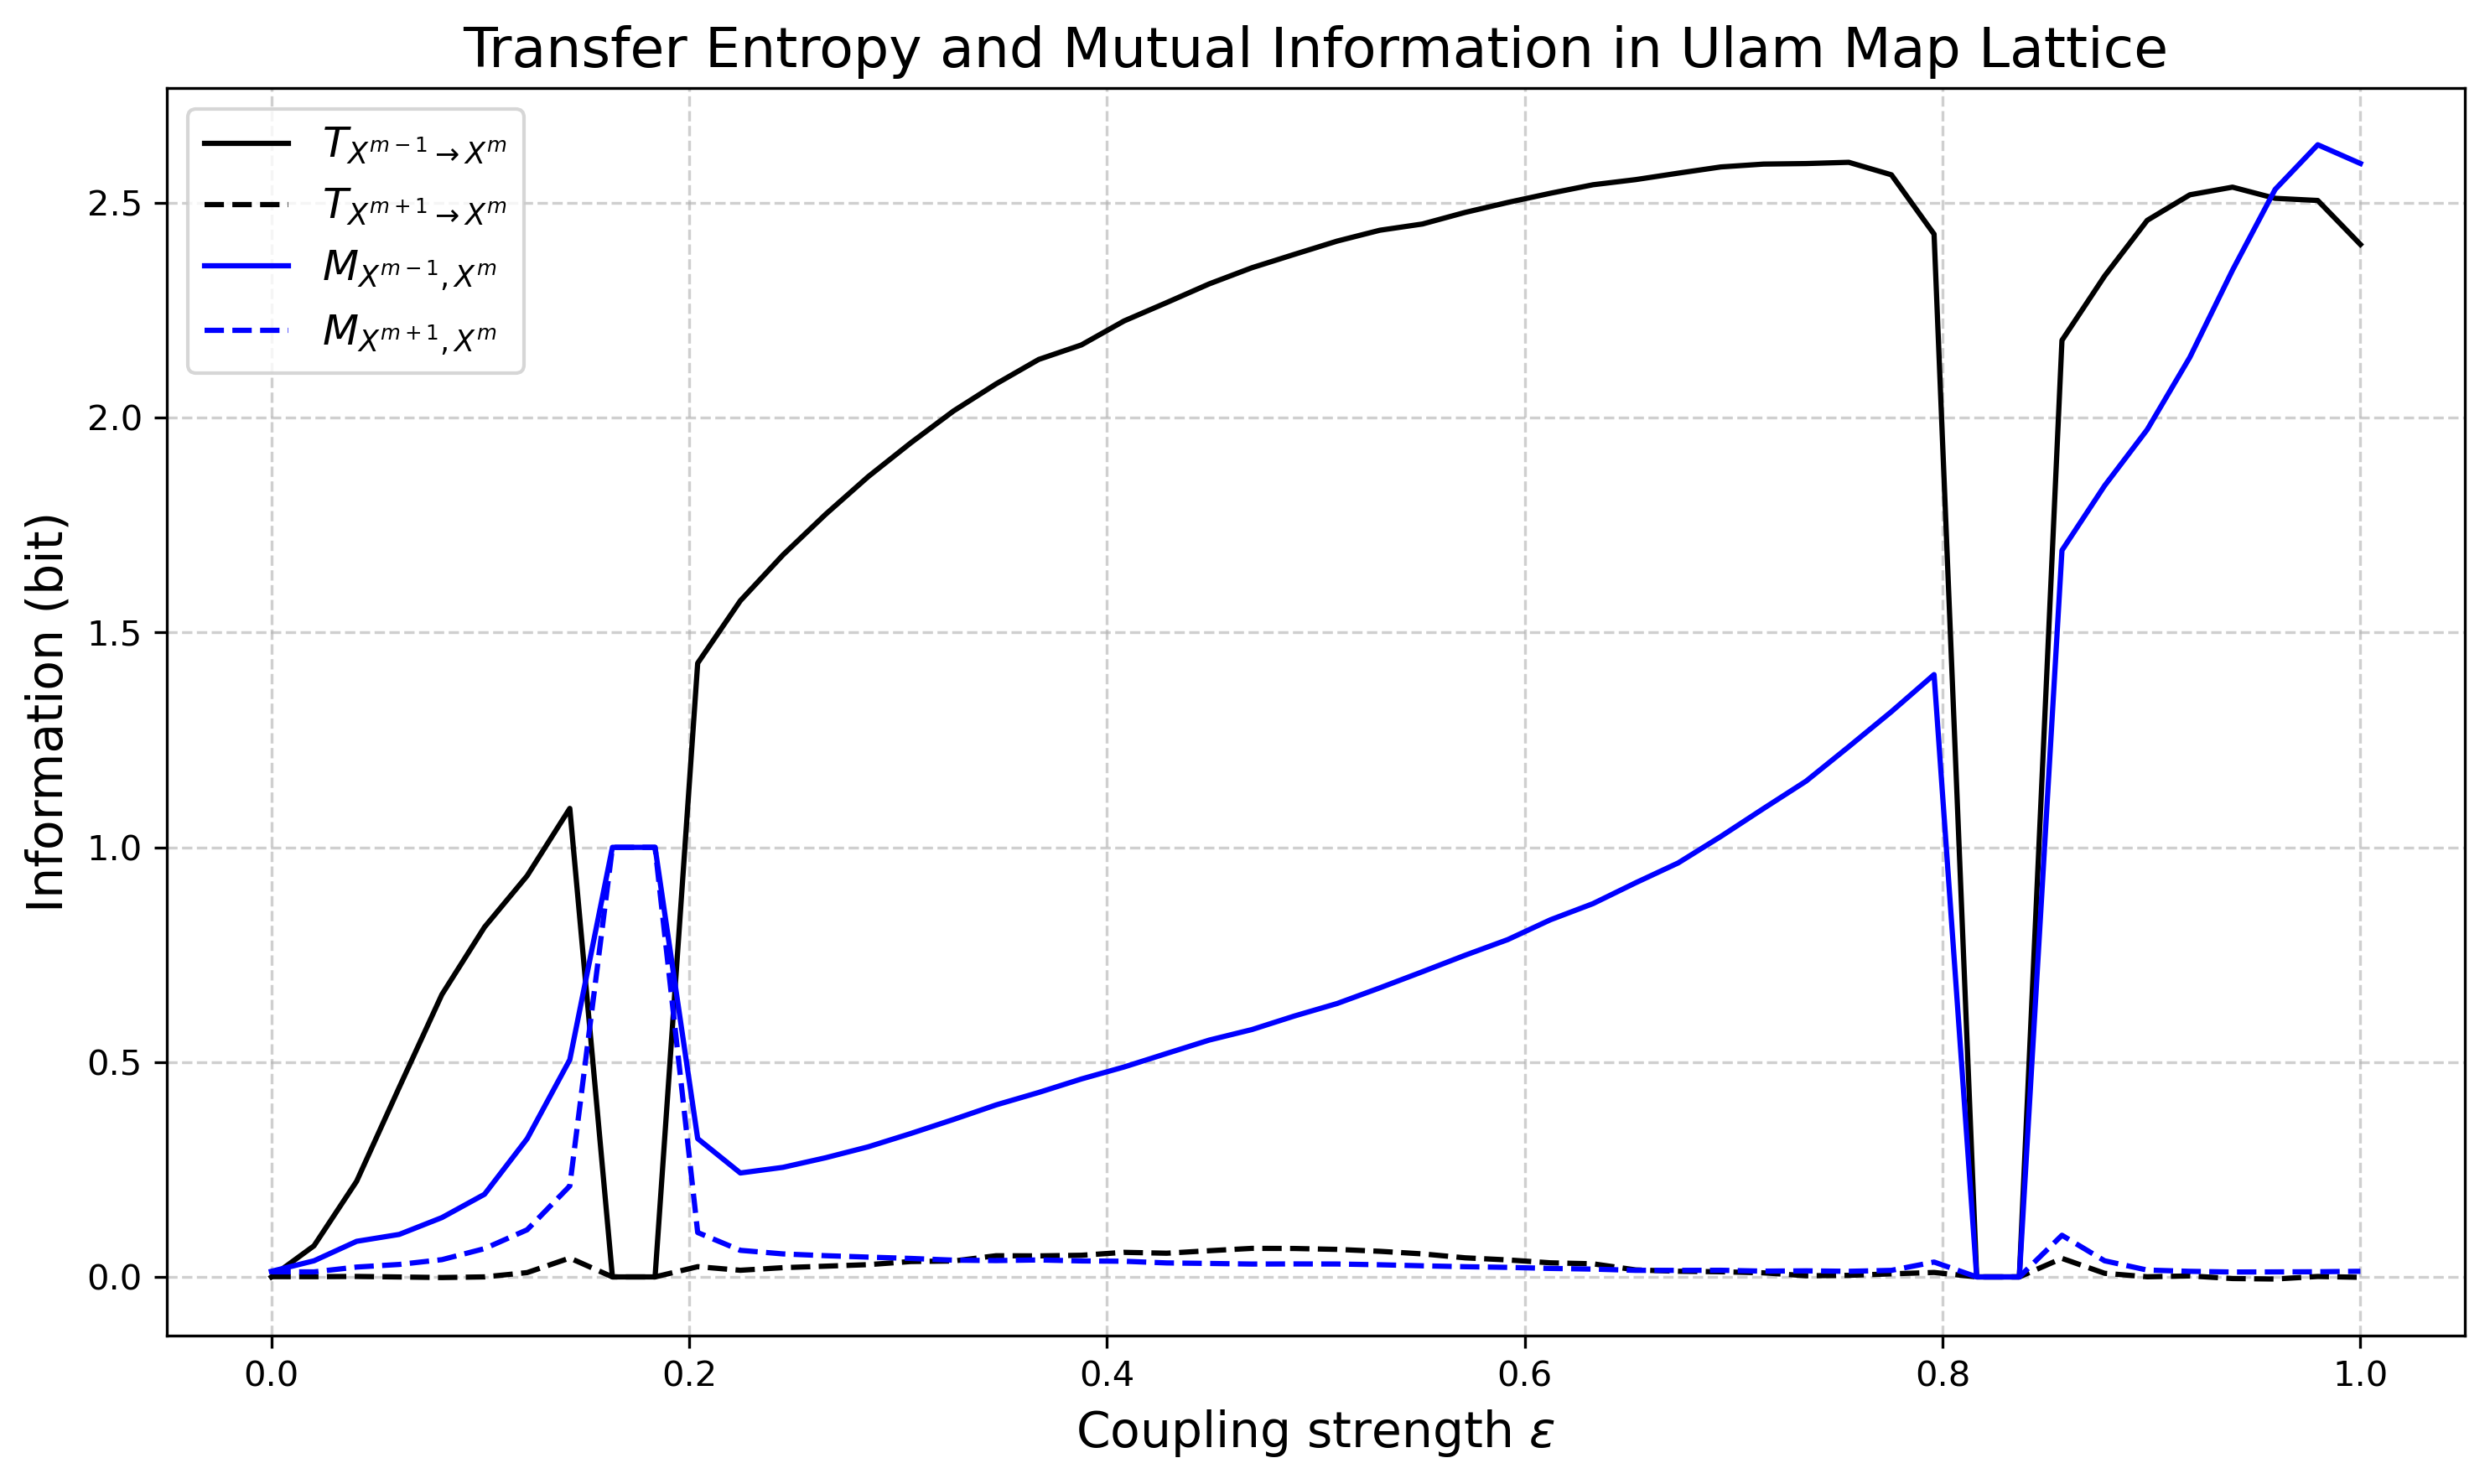

In [11]:
# === Plot Results ===
plt.figure(figsize=(10, 6), dpi=300)

# TE: solid lines
plt.plot(
    coupling_values,
    te_pos,
    label=r"$T_{X^{m-1} \rightarrow X^m}$",
    color="black",
    linestyle="-",
)
plt.plot(
    coupling_values,
    te_neg,
    label=r"$T_{X^{m+1} \rightarrow X^m}$",
    color="black",
    linestyle="--",
)

# MI: dashed lines
plt.plot(
    coupling_values, mi_pos, label=r"$M_{X^{m-1}, X^m}$", color="blue", linestyle="-"
)
plt.plot(
    coupling_values, mi_neg, label=r"$M_{X^{m+1}, X^m}$", color="blue", linestyle="--"
)

plt.xlabel("Coupling strength $\\epsilon$", fontsize=14)
plt.ylabel("Information (bit)", fontsize=14)
plt.title("Transfer Entropy and Mutual Information in Ulam Map Lattice", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("ulam_te_mi_plot.pdf")
plt.show()